In [1]:
## 2.2. k-fold cross validation 
# using a training dataset from the gpr_eos model
# (https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833)

In [16]:
# import required modules
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import datasets

In [3]:
# code for (random) kfold cross validation
if __name__ == "__main__": # https://stackoverflow.com/questions/419163/what-does-if-name-main-do
    # training data is in a CSV (train.csv - i have used my own here)
    df = pd.read_csv("PTX_liq_All_reduced.csv")
    
    # create a new column called kfold and fill with -1
    df["kfold"] = -1
    
    # randomize the rows of data
    df = df.sample(frac=1).reset_index(drop=True)
    
    # initiate the kfold class from model_selection module
    kf = model_selection.KFold(n_splits=5)
    
    # fill the new kfold column
    for fold, (trn_, val_) in enumerate(kf.split(X=df)):
        df.loc[val_, 'kfold'] = fold
    
    # save the new csv with kfold column
    df.to_csv("train_folds.csv", index=False)

In [9]:
# code for stratified kfold cross validation
# this type of kfold is useful when you have a skewed data set (e.g. 90% positive 10% negative)
# in this case you don't want to use a random kfold, instead use stratified kfold where the ratio of labels is kept constant
# I have made a random dataset to use here
if __name__ == "__main__":
    # training data is in a CSV
    df = pd.read_csv("train_skew.csv")
    
    # create a new column called kfold and fill with -1
    df["kfold"] = -1
    
    # randomize the rows of data
    df = df.sample(frac=1).reset_index(drop=True)
    
    #fetch targets
    y = df.target.values
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    # fill the new kfold column
    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, 'kfold'] = f
    
    # save the new csv with kfold column
    df.to_csv("train_folds_strat.csv", index=False)

Text(0, 0.5, 'count')

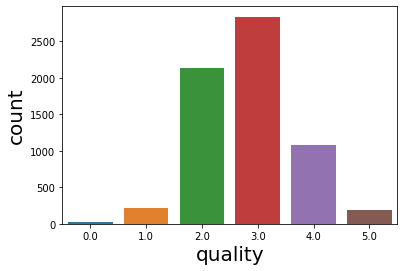

In [12]:
# for the red wine quality dataset used before, lets look at the distribution of labels
import seaborn as sns
df = pd.read_csv('https://raw.githubusercontent.com/insaid2018/Term-1/master/Data/Projects/winequality.csv')
quality_mapping = {
    3: 0,
    4: 1,
    5: 2,
    6: 3,
    7: 4,
    8: 5
}

df.loc[:, "quality"] = df.quality.map(quality_mapping)

b = sns.countplot(x='quality', data=df)
b.set_xlabel("quality", fontsize=20)
b.set_ylabel("count", fontsize=20)

In [14]:
# here it is clear that some labels have far more samples in that others
# for a standard classification problem it is nearly always best to use stratified kfold

## hold-out

# however using a 5 fold cross validation on a dataset of 1 million samples would mean training on 800k samples
# and testing on 200k - this can be very expensive and hold-out based validation should be used
# the process for creating a hold-out dataset is the same as stratified k-fold
# for 1 million samples with 10 folds, we take 900k samples for training and then always use the remaining 100k
# samples to calculate accuracy metrics on

# hold-out is frequently used with time-series data
# say we have time steps 0 to 30 and we want to predicit 31 to 40, we can hold steps 21 to 30 for validation and train
# on steps 0 to 20
# NOTE: when using the model to predicit 31 to 40, steps 21 to 30 should be included in the model otherwise performance 
# will be sub-par

## small datasets

# for small datasets we can't afford to take out too much data, therefore use a type of kfold where k=N
# here the number of folds (k) is equal to the number of samples (N)
# this means in all the folds of training we are training on all the data, except 1 sample
# this can be costly in terms of time, but as it is only used with small datasets this isn't too much of a problem

## regression

# now we can consider the regression case
# can can use all the cross validation methods mentioned, except stratified kfold
# generally for a regression problem a simple kfold will work, if however a distribution of target is not consistent
# then it is possible to adapt the problem so that stratified kfold can be used for regression

# to perform a stratified kfold in a regression setting we first need to divide the target into bins
# for large (> 10k, > 100k) datasets, it doesn't really matter how many bins are used, 10 or 20 are fine
# for smaller datasets Sturge's Rule should be used:

# Number of Bins = 1 + log2(N)

# where N is the number of samples

In [36]:
# stratified kfold for regression
def create_folds(data):
    # create a new column call kfold and fill with -1
    data["kfold"] = -1
    
    # randomize the rows of data
    data = data.sample(frac=1).reset_index(drop=True)
    
    # calculate the number of bins using Sturge's Rule
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin targets
    data.loc[:, "bins"] = pd.cut(
    data["target"], bins=num_bins, labels=False
    )
    
    # initiate the kfold class from model_selection module
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    # fill the new kfold column
    # note instead of targets, bins are used
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
        
    # drop the bins column
    data = data.drop("bins", axis=1)
    # return df with folds
    return data

if __name__ == "__main__":
    # here we create a sample dataset with 15000 samples and 100 features and 1 target
    X, y = datasets.make_regression(
        n_samples=15000, n_features=100, n_targets=1
    )
    
    # create a df out of our np arrays
    df = pd.DataFrame(
        X,
        columns=[f"f_{i}" for i in range(X.shape[1])]
    )
    df.loc[:, "target"] = y
    
    # create folds
    df = create_folds(df)

df

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_92,f_93,f_94,f_95,f_96,f_97,f_98,f_99,target,kfold
0,-0.774555,-1.773382,1.130778,0.815117,-1.594849,-0.032617,-0.154090,0.323289,1.472164,-0.927411,...,-1.086707,0.711119,-1.311827,-0.774696,0.786107,1.254459,1.248586,0.010472,-87.727574,0
1,0.612155,0.055304,-0.641272,0.742241,0.776100,0.318328,0.899198,1.491930,1.129125,-0.124982,...,1.590786,0.199018,-0.826898,0.696414,0.537090,-0.205029,0.553149,0.352159,62.675920,0
2,-0.272502,-0.226216,-0.560199,0.201055,0.727764,-0.554591,0.730228,-0.536563,-0.388146,2.473579,...,0.644352,-0.386575,0.486080,0.092672,-0.844465,0.728180,-0.695450,1.475788,350.866704,0
3,0.154180,0.747576,1.289414,-1.210075,0.055685,-0.420973,-1.619377,-0.297873,0.604649,0.276335,...,-0.184078,-0.256804,-1.108195,1.189292,-0.070460,0.412885,-0.029267,-2.991813,-137.205989,0
4,-0.360387,-0.529910,-0.497947,-0.898662,-0.544286,-0.971647,-1.028042,0.014763,0.540153,-1.292305,...,-0.909205,0.568997,0.924149,-0.791840,-0.381154,0.674265,-2.442922,0.264026,86.090442,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.294899,-0.835134,0.378512,-0.093931,0.068189,0.270619,1.015385,-0.456247,-1.766488,1.166689,...,2.324996,1.593860,-2.335581,0.613897,-1.096858,1.779097,2.686735,0.701123,48.552951,4
14996,0.725418,0.045458,1.621616,-1.821775,-0.549676,-0.187827,1.520519,-1.053870,-1.156351,1.425287,...,-1.296561,0.589363,-1.001864,0.970184,0.525301,1.446674,0.078825,0.775349,-209.246668,4
14997,0.754218,0.890882,-0.288758,-0.129470,1.565819,-0.031624,-0.922864,0.372079,-0.208797,-0.145711,...,2.358575,-0.079931,2.464107,-0.257328,0.058097,0.879807,-0.152887,0.135439,34.582027,4
14998,0.620541,0.571963,1.380499,-0.253306,-0.693747,-1.205632,0.052820,0.041744,0.547760,-0.788660,...,0.260384,-0.726069,-1.537830,1.020104,-0.362191,-1.066223,1.512754,1.195384,89.142345,4


In [37]:
# cross validation is the first and most important step when building ml models
# whatever ml is being done, split the data first
# if a good cross validation scheme is used, where validation (test) data is representative of training and real-world data
# then you can build a good ml model

# the cross validation scheme used depends on the data, and often the scheme may have to be adapted to suit the data
# for example, if the problem is to build a model that takes a picture of a patient as identifies if skin cancer is present
# then stratified classification would be the go to, as it is a binary classification problem
# however, there will be multiple images of the same patient in the training dataset, and therefore you need to make sure
# the same patient isn't in both the training and test dataset. Sci-kit learn has a built in called GroupKFold where the 
# patients would be considered as groups. Currently you cannot combine stratified and group so this needs to be done by 
# the user